In [19]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

In the z-folded cavity, we have ten relevant variables, which are shown in the diagram below.
![title](zfolddiagram.png)
The variables depicted are the length of one arm $L_1$, the angle of one arm w.r.t. the curved mirror $\theta_1$, the distance of the brewster plate from the curved mirror $z_1$, the distance between the two curved mirrors $z$, the angle of the other arm w.r.t the other curved mirror $\theta_2$, the lenght of the other arm $L_2$, the two waists at the center of the brewster plate $\tilde{w_x}$ and $\tilde{w_y}$, and the two waists at the output coupler, $w_x$, and $w_y$. Note that the $w$'s are all functions of the other parameters. We demand the following:

$$
(w_x - w_y)= 0 \\
\frac{d(w_x - w_y)}{dz} = 0 \\
\frac{d(\tilde{w_x}\tilde{w_y})}{dz_1} = 0 \\
\text{cavity } \text{stability} \\
\theta_1 = \theta_2 
$$

The first equation says that the beam is round at the output. The second says the beam should remain round even when the laser is perturbed. The third says the brewster plate has to be at the tightest focus. We will determine what cavity stability means later in the numerical analysis, and the last equation, demanding the angles are equal, is our choice, because we have enough degrees of freedom. Then, we have four equations and five parameters, $L_1, L_2, z, z_1$ and $\theta_1 = \theta_2 = \theta$. This gives us one free parameter, to tune both the round trip time, and the beam waist at the output coupler. Approximate $z_1$ = $z/2$ to simplify the analysis.

Finally, the two small arrows indicate how we start our ABCD matrices to obtain the relevant quantities.

We start the analysis by writing down the ABCD matrices of each optical element.

In [20]:
def freemat(length):
    return np.matrix([[1, length], [0, 1]])


def ybrewstermat(n1, width):
    return np.matrix([[1, width / n1], [0, 1]])


def xbrewstermat(n1, width):
    return np.matrix([[1, width / n1**3], [0, 1]])


def xmirrormat(theta, rmirror):
    return np.matrix([[1, 0],
                      [-2 / (rmirror * np.cos(theta)), 1]])

def ymirrormat(theta, rmirror):
    return np.matrix([[1, 0],
                      [-2 / (rmirror) * np.cos(theta), 1]])

Next, we multiply the matrices and compute the two relevant waists.

In [47]:
def twowaists(midlen, theta,
              rmir=100, nbrew=1.5, brewwid=2, 
              arm1len=1000.,
              armlenratio=1.1,
              lamda=1.56 * 10**(-3)):
    arm2len = arm1len * armlenratio
    brewlen = midlen/2
    
    xarm2 = freemat(2 * arm2len)
    xmirror = xmirrormat(2 * theta, rmir)
    xtobrew = freemat(brewlen)
    xbrew = xbrewstermat(nbrew, brewwid)
    xtom1 = freemat(midlen - brewlen - brewwid)
    xarm1 = freemat(2 * arm1len)
    
    xabcd = xmirror * \
            xtobrew * xbrew * xtom1 * xmirror * \
            xarm2 * xmirror * \
            xtom1 * xbrew * xtobrew * xmirror * \
            xarm1
            
    xa = xabcd[0, 0]
    xc = xabcd[1, 0]
    xd = xabcd[1, 1]
    
    yarm2 = freemat(2 * arm2len)
    ymirror = ymirrormat(2 * theta, rmir)
    ytobrew = freemat(brewlen)
    ybrew = ybrewstermat(nbrew, brewwid)
    ytom1 = freemat(midlen - brewlen - brewwid)
    yarm1 = freemat(2 * arm1len)
    
    yabcd = ymirror * \
            ytobrew * ybrew * ytom1 * ymirror * \
            yarm2 * ymirror * \
            ytom1 * ybrew * ytobrew * ymirror * \
            yarm1

    ya = yabcd[0, 0]
    yc = yabcd[1, 0]
    yd = yabcd[1, 1]
    
    if ( (np.abs(xa + xd) / 2 < 1) and 
        (np.abs(ya + yd) / 2 < 1) ):
        
        xoutwaist = np.sqrt(lamda * np.sqrt(4 - (xa + xd)**2) /
                            2 * np.pi * np.abs(xc))
        
        youtwaist = np.sqrt(lamda * np.sqrt(4 - (ya + yd)**2) /
                            2 * np.pi * np.abs(yc))
        
    else:
        xoutwaist = np.nan
        youtwaist = np.nan
    '''    
    xabcd = xtobrew * xbrew * xtom1 * xmirror * \
            xarm1 * xmirror * \
            xtom1 * xbrew * xtobrew * xmirror * \
            xarm2 * xmirror
            
    xa = xabcd[0, 0]
    xc = xabcd[1, 0]
    xd = xabcd[1, 1]
    
    yabcd = ytobrew * ybrew * ytom1 * ymirror * \
            yarm1 * ymirror * \
            ytom1 * ybrew * ytobrew * ymirror * \
            yarm2 * ymirror
            
    ya = yabcd[0, 0]
    yc = yabcd[1, 0]
    yd = yabcd[1, 1]
    
    if ( (np.abs(xa + xd) / 2 < 1) and 
        (np.abs(ya + yd) / 2 < 1) ):
        
        xmidwaist = np.sqrt(lamda * np.sqrt(4 - (xa + xd)**2) /
                            2 * np.pi * np.abs(xc))
        
        ymidwaist = np.sqrt(lamda * np.sqrt(4 - (ya + yd)**2) /
                            2 * np.pi * np.abs(yc))
        
    else:
        xmidwaist = np.nan
        ymidwaist = np.nan
    '''    
    return np.array([xoutwaist, youtwaist])

We've enforced two of our five constraints already: cavity stability and $\theta_1 = \theta_2$. What remains are the three other constraints.

In [48]:
rmir = 100
ngain = 1.5
lgain = 2.0
lamda = 1.56 * 10**(-3)

lmiddles = np.arange(52, 58, .01)
thetas = np.arange(.1, 10.1, 1) * np.pi / 180.0

In [52]:
results = np.array([[twowaists(l, theta, arm1len=750) for l in lmiddles] for theta in thetas])

In [53]:
thetas

array([ 0.00174533,  0.01919862,  0.03665191,  0.05410521,  0.0715585 ,
        0.08901179,  0.10646508,  0.12391838,  0.14137167,  0.15882496])

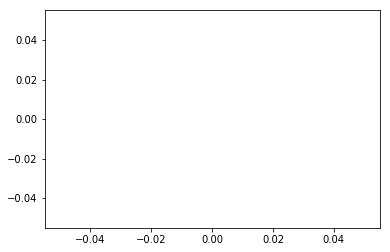

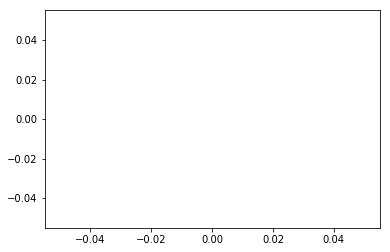

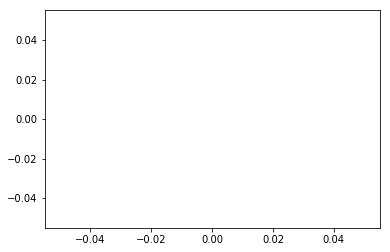

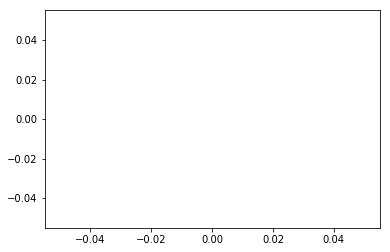

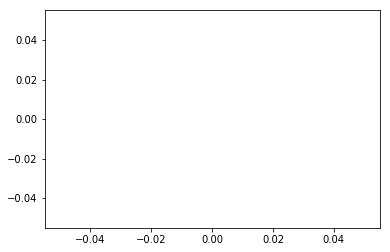

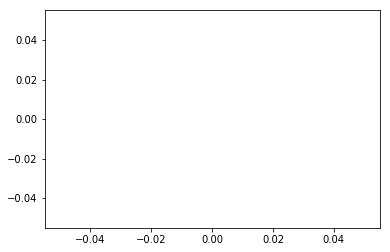

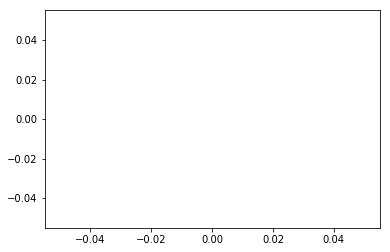

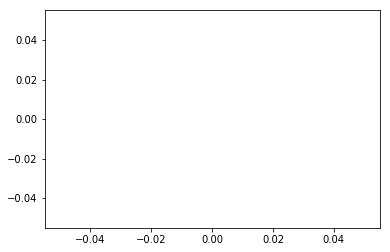

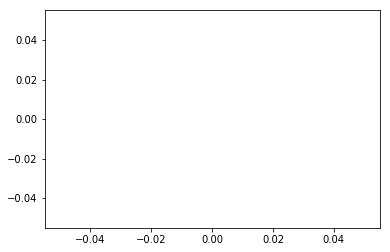

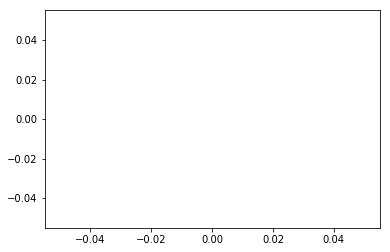

In [54]:
for j in range(len(thetas)):
    plt.figure(j)
    plt.plot(lmiddles, results[j, :, 0], lmiddles, results[j, :, 1])

    plt.show()